In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/ACB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

          Price       Open       High        Low    Vol. Change %
0     11,361.00  11,285.20  11,398.80  11,171.60   3.91M    1.01%
1     11,512.40  11,361.00  11,550.30  11,323.10   8.24M    1.33%
2     11,474.60  11,512.40  11,626.00  11,398.80   6.51M   -0.33%
3     11,474.60  11,436.70  11,512.40  11,361.00   3.11M    0.00%
4     11,550.30  11,512.40  11,626.00  11,474.60   8.72M    0.66%
...         ...        ...        ...        ...     ...      ...
1303  29,450.00  29,500.00  29,850.00  29,250.00   7.54M    0.68%
1304  29,650.00  29,700.00  29,700.00  29,300.00  10.69M    0.68%
1305  29,250.00  29,700.00  29,750.00  29,250.00  13.45M   -1.35%
1306  25,565.20  25,347.80  25,565.20  25,087.00  15.08M  -12.60%
1307  24,650.00  25,000.00  25,300.00  24,650.00  11.12M   -3.58%

[1308 rows x 6 columns]


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low      Vol.  Change %
0     11361.0  11285.2  11398.8  11171.6   3910000    0.0101
1     11512.4  11361.0  11550.3  11323.1   8240000    0.0133
2     11474.6  11512.4  11626.0  11398.8   6510000   -0.0033
3     11474.6  11436.7  11512.4  11361.0   3110000    0.0000
4     11550.3  11512.4  11626.0  11474.6   8720000    0.0066
...       ...      ...      ...      ...       ...       ...
1303  29450.0  29500.0  29850.0  29250.0   7540000    0.0068
1304  29650.0  29700.0  29700.0  29300.0  10690000    0.0068
1305  29250.0  29700.0  29750.0  29250.0  13450000   -0.0135
1306  25565.2  25347.8  25565.2  25087.0  15080000   -0.1260
1307  24650.0  25000.0  25300.0  24650.0  11120000   -0.0358

[1308 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1308.000000,1308.000000,1308.000000,1308.000000,1.308000e+03,1308.000000
mean,19251.080122,19252.003287,19477.664526,19027.109098,7.817892e+06,0.000792
std,5987.083276,5994.933392,6038.280436,5938.080094,6.166880e+06,0.019501
min,8763.100000,7926.200000,9255.400000,7926.200000,7.420600e+05,-0.175200
25%,12075.875000,12110.800000,12258.375000,11914.000000,3.487500e+06,-0.008000
50%,20466.000000,20466.000000,20674.000000,20219.500000,6.005000e+06,0.000000
75%,24412.000000,24056.000000,24568.000000,23891.500000,1.023500e+07,0.009100
max,30360.000000,30400.000000,30560.000000,29300.000000,4.873000e+07,0.096100


In [5]:
df1=df.reset_index()['Price']
df1

0       11361.0
1       11512.4
2       11474.6
3       11474.6
4       11550.3
         ...   
1303    29450.0
1304    29650.0
1305    29250.0
1306    25565.2
1307    24650.0
Name: Price, Length: 1308, dtype: float64

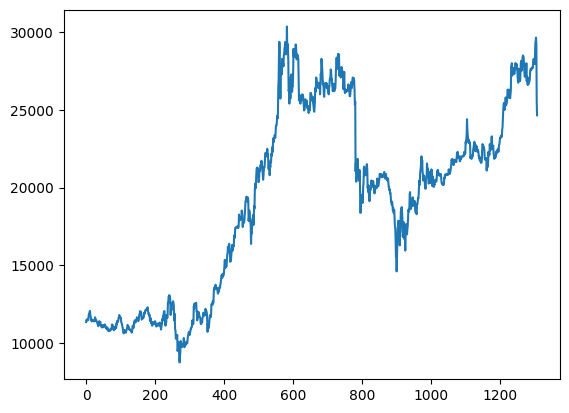

In [6]:
plt.plot(df1)

## LSTM are sentitive to the scale of the data => apply MinMax schaler

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# df1.shape
print(df1)

[[0.12029041]
 [0.12730068]
 [0.12555043]
 ...
 [0.94860373]
 [0.77798666]
 [0.7356102 ]]


In [9]:
# 4. split the data into train and test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [10]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# c. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
print(X_train)

[[[0.12029041]
  [0.12730068]
  [0.12555043]
  ...
  [0.13782534]
  [0.13431557]
  [0.13256069]]

 [[0.12730068]
  [0.12555043]
  [0.12555043]
  ...
  [0.13431557]
  [0.13256069]
  [0.13449152]]

 [[0.12555043]
  [0.12555043]
  [0.12905556]
  ...
  [0.13256069]
  [0.13449152]
  [0.12765258]]

 ...

 [[0.47029435]
  [0.48575953]
  [0.46450648]
  ...
  [0.54766656]
  [0.5592423 ]
  [0.55734388]]

 [[0.48575953]
  [0.46450648]
  [0.48575953]
  ...
  [0.5592423 ]
  [0.55734388]
  [0.55734388]]

 [[0.46450648]
  [0.48575953]
  [0.48964898]
  ...
  [0.55734388]
  [0.55734388]
  [0.55734388]]]


In [12]:
# # 8. Build LSTM modal

# # Define the model
# model = Sequential()

# # Add a 1D convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# # Add a max pooling layer
# model.add(MaxPooling1D(pool_size=2))

# # Add another 1D convolutional layer
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# # Add a bidirectional LSTM layer
# model.add(Bidirectional(LSTM(100, activation='relu')))

# # Add a dense output layer
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\mikey\OneDrive\Desktop\LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.1283 - val_loss: 0.0540
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0137 - val_loss: 0.0103
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2

In [16]:
# 10. Dự báo dữ liệu test
# train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [17]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
# train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [18]:
##Transformback to original form
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)   

Testing RMSE: 531.4868213006264
Testing MAE: 363.78052940605556
Testing MAPE: 0.014123051876582207


In [20]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,y_pred))

531.4868213006264

In [21]:
len(test_data)

262

In [22]:
# x_input = test_data[162:].reshape(1,-1)
# x_input.shape

In [23]:
# temp_input = list(x_input)
# temp_input = temp_input[0].tolist()

In [24]:
# temp_input

In [25]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

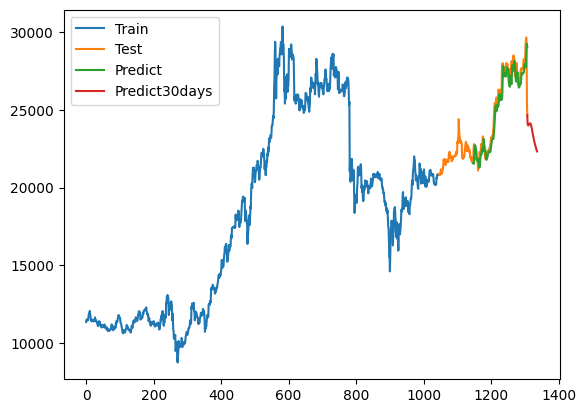

In [26]:
# 15.Vẽ hình dự báo 30 ngày tiếp theo

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [27]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

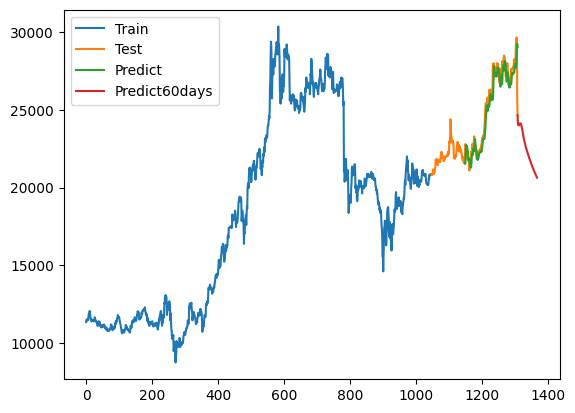

In [28]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_60)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_60))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [29]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

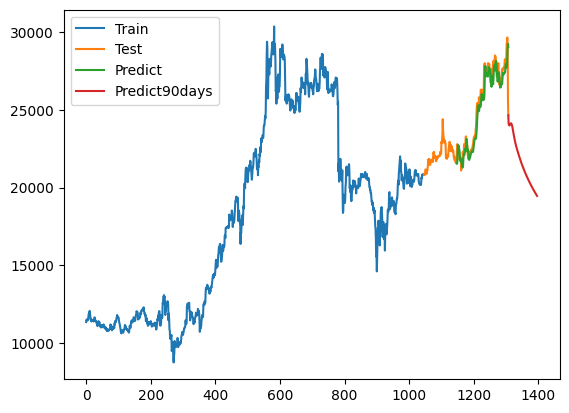

In [30]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_90)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_90))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()